In [1]:
import kagglehub

import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from pathlib import Path
import numpy as np

import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4


/Users/mikolajkahl/kahlus2001/mobile-net-mushroom-classification/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Load Dataset from Kaggle

In [2]:
# Download latest version of dataset from kaggle url(https://www.kaggle.com/datasets/derekkunowilliams/mushrooms)
path = kagglehub.dataset_download("derekkunowilliams/mushrooms")
source_root = Path(os.path.join(path, "mushroom_dataset"))
print("Path to dataset files:", source_root)

Path to dataset files: /Users/mikolajkahl/.cache/kagglehub/datasets/derekkunowilliams/mushrooms/versions/1/mushroom_dataset


In [3]:
# Root path of the dataset
root_dir = "mushroom_dataset_4class"

dest_root = Path(root_dir)
if not dest_root.exists():
    dest_root.mkdir(exist_ok=True)

    # Define the top-level labels
    labels = ["edible", "deadly", "poisonous", "conditionally_edible"]

    # Create destination folders and flatten species into category
    for label in labels:
        src_label_path = source_root / label
        dst_label_path = dest_root / label
        dst_label_path.mkdir(parents=True, exist_ok=True)

        for species_dir in src_label_path.iterdir():
            if species_dir.is_dir():
                for img_file in species_dir.glob("*.*"):  # Match .png, .jpg, etc.
                    # Generate a unique filename to avoid overwriting
                    dest_file = dst_label_path / f"{species_dir.name}_{img_file.name}"
                    shutil.copy(img_file, dest_file)

    print("Dataset flattened to 4-class format at:", dest_root.resolve())
else:
    print("Directory 'mushroom_dataset_4class' already exists. Skipping operation.")


Directory 'mushroom_dataset_4class' already exists. Skipping operation.


### 2. Basic Exploratory Data Analysis

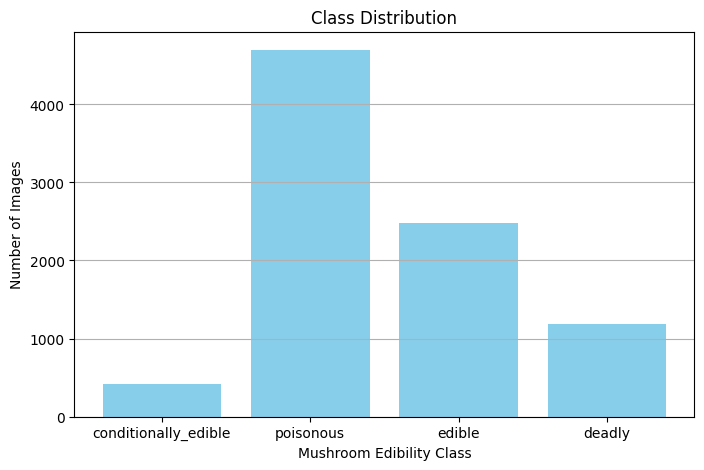

In [4]:
# Count number of images per class
class_counts = {}
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len([
            f for f in os.listdir(class_path) 
            if os.path.isfile(os.path.join(class_path, f))
        ])

# Plot
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Mushroom Edibility Class")
plt.grid(True, axis='y')
plt.show()


In [5]:
df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
print(df.sort_values("Count", ascending=False))

                  Class  Count
1             poisonous   4696
2                edible   2475
3                deadly   1190
0  conditionally_edible    420


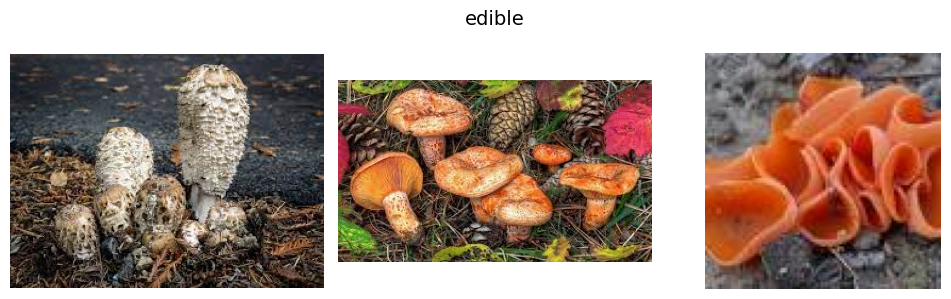

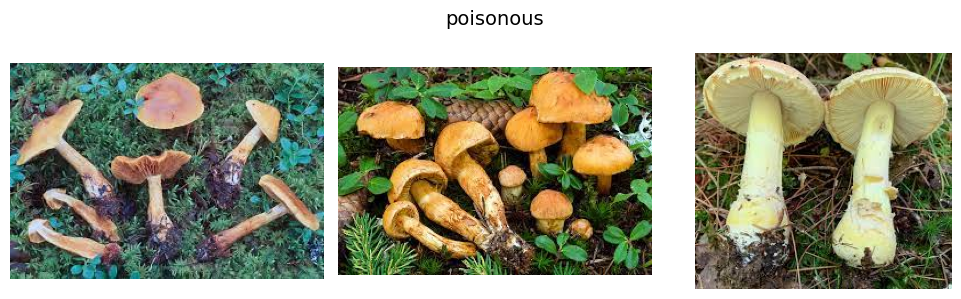

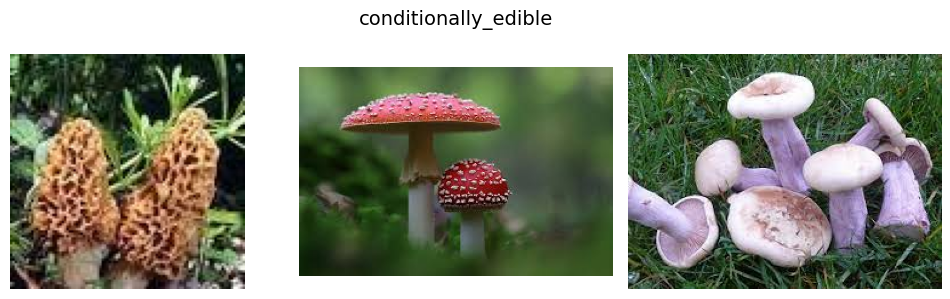

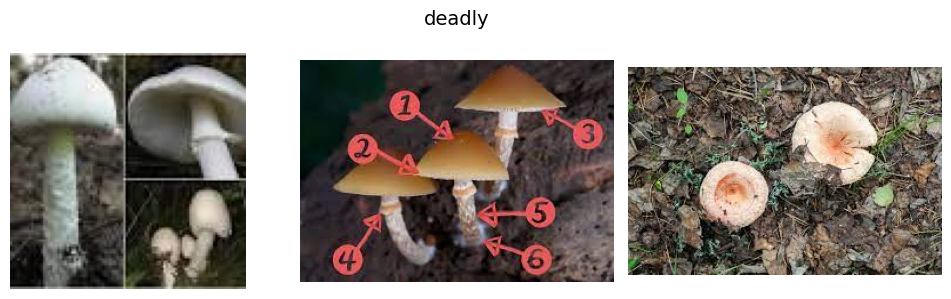

In [6]:
# Root directory with your 4 classes
data_dir = "mushroom_dataset_4class"
class_names = ["edible", "poisonous", "conditionally_edible", "deadly"]

def show_3_random_images_per_class():
    for class_name in class_names:
        class_path = os.path.join(root_dir, class_name)
        all_images = os.listdir(class_path)
        sample_imgs = random.sample(all_images, min(3, len(all_images)))

        plt.figure(figsize=(10, 3))
        for i, img_name in enumerate(sample_imgs):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')

        plt.suptitle(f"{class_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

show_3_random_images_per_class()


### 3. Train-Test split

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 8781 files belonging to 4 classes.
Using 7025 files for training.
Found 8781 files belonging to 4 classes.
Using 1756 files for validation.


In [8]:
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Image dtype: {images.dtype}")
    print(f"Label dtype: {labels.dtype}")


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>


2025-04-09 23:39:39.259454: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
def get_augmentation(name):
    if name == "flip":
        return tf.keras.Sequential([
            layers.RandomFlip("horizontal")
        ])
    elif name == "flip_zoom":
        return tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomZoom(0.1)
        ])
    elif name == "flip_rotate":
        return tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.15)
        ])
    else:  # default / none
        return tf.keras.Sequential([])


### 4. Model Training Testing Framework

In [10]:
def get_classifier(name):
    if name == "simple":
        return [
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(NUM_CLASSES, activation='softmax')
        ]
    elif name == "deep":
        return [
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(NUM_CLASSES, activation='softmax')
        ]
    elif name == "minimal":
        return [
            layers.GlobalAveragePooling2D(),
            layers.Dense(NUM_CLASSES, activation='softmax')
        ]
    else:
        raise ValueError("Unknown classifier head")


In [11]:
def build_model(fine_tune, fine_tune_at, augmentation_name, classifier_name):
    base_model = MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    if fine_tune:
        base_model.trainable = True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
    else:
        base_model.trainable = False

    data_aug = get_augmentation(augmentation_name)
    classifier_head = get_classifier(classifier_name)

    model = models.Sequential([
        layers.InputLayer(input_shape=(*IMG_SIZE, 3)),
        data_aug,
        base_model,
        *classifier_head
    ])
    return model


In [12]:
def train_model(model, learning_rate=1e-5, epochs=10):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )
    return model, history


In [13]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [14]:
def plot_confusion_matrix(model):
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()


In [15]:
def run_experiment(name, fine_tune, fine_tune_at, learning_rate, epochs, augmentation_name, classifier_name):
    print(f"\nRunning: {name} ({'fine-tuned' if fine_tune else 'frozen'})")
    model = build_model(
        fine_tune=fine_tune,
        fine_tune_at=fine_tune_at,
        augmentation_name=augmentation_name,
        classifier_name=classifier_name
    )

    model, history = train_model(
        model,
        learning_rate=learning_rate,
        epochs=epochs
    )

    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]

    print(f"{name} done | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    return {
        "name": name,
        "fine_tune": fine_tune,
        "fine_tune_at": fine_tune_at,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "augmentation": augmentation_name,
        "classifier": classifier_name,
        "val_accuracy": val_acc,
        "val_loss": val_loss,
        "history": history
    }


### 5. Training Experiments

In [16]:
experiments = [
    # 🚫 Baseline (frozen)
    {
        "name": "baseline_non_finetuned",
        "fine_tune": False,
        "fine_tune_at": None,
        "learning_rate": 1e-3,
        "epochs": 10,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    # 🔄 Light fine-tuning
    {
        "name": "ft_last_30_flip_simple",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-5,
        "epochs": 10,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    {
        "name": "ft_last_50_zoom_deep",
        "fine_tune": True,
        "fine_tune_at": -50,
        "learning_rate": 5e-5,
        "epochs": 10,
        "augmentation_name": "flip_zoom",
        "classifier_name": "deep"
    },

    {
        "name": "ft_last_80_rotate_minimal",
        "fine_tune": True,
        "fine_tune_at": -80,
        "learning_rate": 1e-5,
        "epochs": 10,
        "augmentation_name": "flip_rotate",
        "classifier_name": "minimal"
    },

    # 🔥 Full fine-tuning
    {
        "name": "ft_all_layers_flip_simple",
        "fine_tune": True,
        "fine_tune_at": 0,
        "learning_rate": 1e-5,
        "epochs": 10,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    {
        "name": "ft_all_layers_zoom_deep",
        "fine_tune": True,
        "fine_tune_at": 0,
        "learning_rate": 5e-6,
        "epochs": 10,
        "augmentation_name": "flip_zoom",
        "classifier_name": "deep"
    },

    {
        "name": "ft_all_layers_rotate_minimal",
        "fine_tune": True,
        "fine_tune_at": 0,
        "learning_rate": 1e-6,
        "epochs": 10,
        "augmentation_name": "flip_rotate",
        "classifier_name": "minimal"
    }
]


In [ ]:
results = []

for exp in experiments:
    result = run_experiment(
        name=exp["name"],
        fine_tune=exp["fine_tune"],
        fine_tune_at=exp.get("fine_tune_at", -30),  # use default if None
        learning_rate=exp["learning_rate"],
        epochs=exp["epochs"],
        augmentation_name=exp["augmentation_name"],
        classifier_name=exp["classifier_name"]
    )
    results.append(result)



Running: baseline_non_finetuned (frozen)
Epoch 1/10


/Users/mikolajkahl/kahlus2001/mobile-net-mushroom-classification/venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5133 - loss: 1.2138

In [ ]:
df_results = pd.DataFrame(results)[[
    "name", "fine_tune", "fine_tune_at", "learning_rate",
    "epochs", "augmentation", "classifier", "val_accuracy", "val_loss"
]]
df_results = df_results.sort_values("val_accuracy", ascending=False)
df_results
